In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  

In [2]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv, find_behavior_videos_folder, integrate_keypoints_with_video_time

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_751004_2024-12-20_13-26-07/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
#tongue kinematics processing and movement annotation
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4,filter_kind='cubic')
tongue_segmented = segment_movements_trimnans(tongue_filtered, max_dropped_frames=10)


In [ ]:
from kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

nwb = get_nwb_file(session_name)
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_trials = nwb_utils.create_df_trials(nwb)
nwb.df_licks = annotation.annotate_licks(nwb)

NWB file not found for 751004 on 2024-12-20. Generating it now...
Generated NWB file: /root/capsule/scratch/behavior_751004_2024-12-20_13-26-07/751004_2024-12-20_13-26-11.nwb
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


/opt/conda/lib/python3.9/site-packages/aind_dynamic_foraging_data_utils/nwb_utils.py:465: UserWarning: Reward before choice time. This is likely due to manual rewards
  warnings.warn("Reward before choice time. This is likely due to manual rewards")


In [ ]:
def annotate_trials_in_kinematics(tongue_segmented, df_trials):
    """
    Adds 'time_in_session' and 'trial' columns to tongue_segmented dataframe
    by linking to df_trials using goCue timing.
    """
    # Normalize time
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['time_in_session'] = tongue_segmented['time_raw'] - df_trials['goCue_start_time_raw'].iloc[0]

    # Merge to get trial ID
    merged_df = pd.merge_asof(
        tongue_segmented,
        df_trials,
        left_on='time_in_session',
        right_on='goCue_start_time_in_session',
        direction='backward'
    )
    tongue_segmented['trial'] = merged_df['trial']
    
    return tongue_segmented

def annotate_licks_in_kinematics(tongue_segmented, licks_df, tolerance=0.01):
    """
    Marks frames in tongue_segmented that occur near lick timestamps in licks_df.
    
    Adds:
      - 'lick': boolean, True if within tolerance of any lick
      - 'lick_index': index from licks_df of the closest lick (or pd.NA)
    """
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['lick'] = False
    tongue_segmented['lick_index'] = pd.NA

    frame_times = tongue_segmented['time_in_session'].to_numpy()
    lick_times = licks_df['timestamps'].to_numpy()

    for i, lick_time in enumerate(lick_times):
        # Find frames within the time window
        diffs = np.abs(frame_times - lick_time)
        within_tolerance = diffs <= tolerance

        if within_tolerance.any():
            closest_frame = np.argmin(np.where(within_tolerance, diffs, np.inf))
            tongue_segmented.at[closest_frame, 'lick'] = True
            tongue_segmented.at[closest_frame, 'lick_index'] = i  # link back to licks_df

    return tongue_segmented


def assign_movements_to_licks(tongue_segmented, df_licks):
    """
    Maps movement_ids back to licks dataframe
    """
    if not hasattr(tongue_segmented, "lick_index"):
        print("You need to annotate licks into kinematics: annotate_licks_in_kinematics")
        return

    df_licks = df_licks.copy()

    # Map lick_index → movement_id
    #    We drop any frames that weren't matched to a lick (lick_index is NA)
    mapping = (
        tongue_segmented
        .dropna(subset=['lick_index'])
        .groupby('lick_index')['movement_id']
        .first()              # if multiple frames map to the same lick, just take the first
    )
    df_licks['nearest_movement_id'] = df_licks.index.map(mapping).astype('Int64')

    return df_licks




In [ ]:
tongue_segmented = annotate_trials_in_kinematics(tongue_segmented, nwb.df_trials)
tongue_marked = annotate_licks_in_kinematics(tongue_segmented, nwb.df_licks, tolerance=0.01)
nwb.df_licks = assign_movements_to_licks(tongue_marked, nwb.df_licks)


In [ ]:
def aggregate_tongue_movements(tongue_segmented, keypoint_dfs_trimmed):
    """
    Aggregate kinematic and lick features of tongue movements.

    Parameters:
        tongue_segmented (pd.DataFrame): Frame-level data with at least
            'movement_id', 'time_in_session', 'x', 'y', 'xv', 'yv', 'v',df
            'lick', 'lick_index', and 'trial' columns.
        keypoint_dfs_trimmed (dict): Dictionary of keypoint dataframes. 
            Must include 'jaw' with 'x' and 'y' columns.

    Returns:
        pd.DataFrame: One row per movement_id with summary statistics.
    """
    # Ensure lick annotations exist
    if not all(col in tongue_segmented.columns for col in ["lick", "lick_index"]):
        print("You need to annotate licks in kinematics: run annotate_licks_in_kinematics(tongue_segmented, licks_df)")
        return
    
    # Kinematic metrics
    movement_metrics = tongue_segmented.groupby("movement_id").agg(
        start_time = ("time_in_session", "min"),
        end_time   = ("time_in_session", "max"),
        duration=("time_in_session", lambda x: x.max() - x.min()),
        min_x=("x", "min"),
        max_x=("x", "max"),
        min_y=("y", "min"),
        max_y=("y", "max"),
        min_xv=("xv", "min"),
        max_xv=("xv", "max"),
        min_yv=("yv", "min"),
        max_yv=("yv", "max"),
        peak_velocity=("v", "max"),
        mean_velocity=("v", "mean")
    )

    # Total distance traveled
    tongue_sorted = tongue_segmented.sort_values(["movement_id", "time_in_session"])
    distance_list = []
    for movement_id, group in tongue_sorted.groupby("movement_id"):
        group = group.dropna(subset=["x", "y"]).reset_index(drop=True)
        if len(group) < 2:
            total_distance = np.nan
        else:
            distances = np.sqrt(np.diff(group["x"])**2 + np.diff(group["y"])**2)
            total_distance = distances.sum()
        distance_list.append((movement_id, total_distance))
    movement_distances = pd.DataFrame(distance_list, columns=["movement_id", "total_distance"]).set_index("movement_id")

    # Max excursion from jaw
    jaw_mean_position = keypoint_dfs_trimmed['jaw'][['x', 'y']].mean()
    jaw_x, jaw_y = jaw_mean_position['x'], jaw_mean_position['y']
    excursion_data = []
    for movement_id, group in tongue_sorted.groupby("movement_id"):
        group = group.dropna(subset=["x", "y"]).reset_index(drop=True)
        if group.empty:
            continue

        # 1. Find the point furthest from the jaw by Euclidean distance
        euclid_distances = np.sqrt((group["x"] - jaw_x)**2 + (group["y"] - jaw_y)**2)
        idx_euclid = euclid_distances.idxmax()
        row_euclid = group.loc[idx_euclid]
        endpoint_x = row_euclid["x"]
        endpoint_y = row_euclid["y"]

        # Compute angle (0° = forward, increasing counterclockwise)
        dx = endpoint_x - jaw_x
        dy = endpoint_y - jaw_y
        angle_rad = np.arctan2(dy, dx)
        angle_deg = np.degrees(angle_rad)

        # 2. Find the point farthest from jaw in x-direction (by absolute difference)
        abs_diff_x = (group["x"] - jaw_x).abs()
        idx_x = abs_diff_x.idxmax()
        max_x_from_jaw = group.loc[idx_x, "x"]

        # 3. Find the point farthest from jaw in y-direction (by absolute difference)
        abs_diff_y = (group["y"] - jaw_y).abs()
        idx_y = abs_diff_y.idxmax()
        max_y_from_jaw = group.loc[idx_y, "y"]

        # 4. Compute signed distances from jaw for x and y
        max_x_distance = abs(max_x_from_jaw - jaw_x)
        max_y_distance = abs(max_y_from_jaw - jaw_y)

        excursion_data.append({
            "movement_id": movement_id,
            "endpoint_x": endpoint_x,
            "endpoint_y": endpoint_y,
            "max_x_from_jaw": max_x_from_jaw,
            "max_y_from_jaw": max_y_from_jaw,
            "max_x_distance": max_x_distance,
            "max_y_distance": max_y_distance,
            "excursion_angle_deg": angle_deg
        })

    excursions = pd.DataFrame(excursion_data).set_index("movement_id")

    # Lick-related metrics
    lick_info = tongue_segmented.groupby("movement_id").agg(
        has_lick=("lick", "max"),
        first_lick_index=("lick_index", lambda x: x.dropna().min()),
        lick_count=("lick_index", lambda x: x.dropna().nunique())
    )

    # Trial mapping
    # NB: use 'first' because some movements can span a go cue -- and mouse can't 'know' it is coming
    movement_trial = tongue_segmented.groupby("movement_id")["trial"].first()

    # Combine everything
    movements = pd.concat([
        movement_metrics,
        movement_distances,
        excursions,
        lick_info,
        movement_trial.rename("trial")
    ], axis=1).reset_index()

    return movements


In [ ]:
def add_lick_metadata_to_movements(tongue_movements, licks_df, fields=None, lick_index_col='first_lick_index'):
    """
    Adds lick-level metadata (e.g., cue_response) from licks_df to tongue_movements
    using the lick index specified in `lick_index_col`.
    
    Parameters:
    ----------
    tongue_movements : pd.DataFrame
        DataFrame of segmented tongue movements.
    
    licks_df : pd.DataFrame
        Lick events dataframe (e.g., nwb.df_licks).
    
    fields : list of str, optional
        Lick metadata fields to merge into tongue_movements.
        Defaults to ['cue_response'].
    
    lick_index_col : str, optional
        Column in tongue_movements that contains indices into licks_df.
        Defaults to 'first_lick_index'.
    
    Returns:
    -------
    pd.DataFrame
        A copy of tongue_movements with requested lick metadata merged in.
    """

    if fields is None:
        fields = ['cue_response']
    
    # Safety checks
    if not isinstance(tongue_movements, pd.DataFrame):
        raise TypeError("tongue_movements must be a pandas DataFrame.")
    if not isinstance(licks_df, pd.DataFrame):
        raise TypeError("licks_df must be a pandas DataFrame.")
    if lick_index_col not in tongue_movements.columns:
        raise ValueError(
            f"'{lick_index_col}' not found in tongue_movements. "
            f"Ensure you've run earlier steps to annotate lick indices (`annotate_licks_in_movements`, 'aggregate_tongue_movements')."
        )
    for field in fields:
        if field not in licks_df.columns:
            raise ValueError(
                f"'{field}' not found in licks_df. Available columns: {list(licks_df.columns)}"
            )

    # Prepare lick metadata for merge
    licks_meta = licks_df[fields].copy()
    licks_meta = licks_meta.reset_index().rename(columns={'index': lick_index_col})

    # Merge and fill missing values if booleans
    merged = tongue_movements.merge(licks_meta, on=lick_index_col, how='left')
    for field in fields:
        if merged[field].dtype == 'boolean' or merged[field].dtype == bool:
            merged[field] = merged[field].fillna(False)

    return merged


In [ ]:
tongue_movements = aggregate_tongue_movements(tongue_marked,keypoint_dfs_trimmed)

In [ ]:
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    nwb.df_licks,
    fields=['cue_response', 'rewarded']
)


39      39
95      95
150    150
199    199
470    470
Name: trial, dtype: int64
39      39
95      95
100    100
150    150
199    199
390    390
468    468
470    470
Name: trial, dtype: int64
1186    100
4243    390
5019    468
Name: trial, dtype: int64


/tmp/ipykernel_3027/3503801240.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


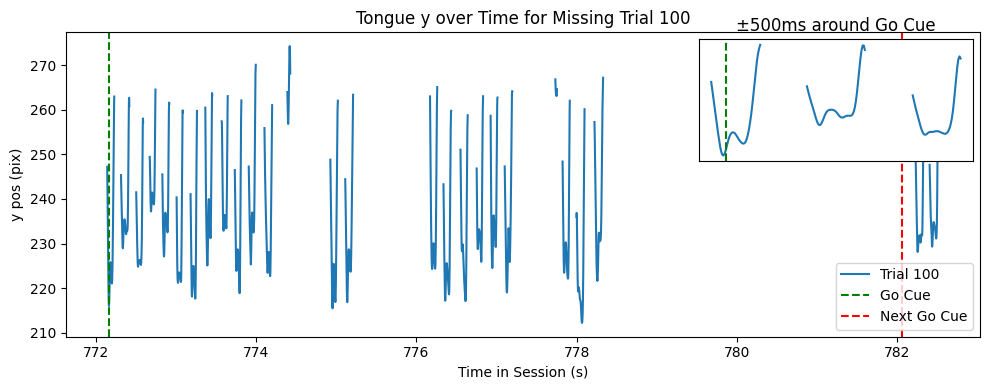

In [12]:
# analysis for why there are less trials with cue response lick as we process:
# df_trials --> df_licks: reason is due to responses that are longer than CUE_TO_LICK_TOLERANCE (currently 1 second 06/02/2025)
# df_licks --> tongue_movements: reason is due to 'lick before go' where tongue movement starts right before go cue. (or grooming)
# considering whether this should be defined as latter trial instead. 
# using: LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'


# Filter the two DataFrames
trials_with_response = nwb.df_trials[nwb.df_trials['animal_response'].isin([0, 1])]
lick_trials_with_cue_response = nwb.df_licks[nwb.df_licks['cue_response'] == True]
tongue_movements_with_cue_response = tongue_movements[tongue_movements['cue_response']==True]

# Identify trials in df_trials that are not in df_licks
missing_trials = trials_with_response[~trials_with_response['trial'].isin(lick_trials_with_cue_response['trial'])]
missing_trials2 = trials_with_response[~trials_with_response['trial'].isin(tongue_movements_with_cue_response['trial'])]
missing_trials3 = lick_trials_with_cue_response[~lick_trials_with_cue_response['trial'].isin(tongue_movements_with_cue_response['trial'])]

# View the result
print(missing_trials['trial'])
print(missing_trials2['trial'])
print(missing_trials3['trial'])

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Step 2: Choose one missing trial (e.g., the first one)
trial_id = missing_trials3.iloc[0]['trial']

# Step 3: Get go cue time for this trial and the next one
trial_idx = nwb.df_trials[nwb.df_trials['trial'] == trial_id].index[0]

trial_idx = 1

go_cue = nwb.df_trials.loc[trial_idx, 'goCue_start_time_in_session']
try:
    next_go_cue = nwb.df_trials.loc[trial_idx + 1, 'goCue_start_time_in_session']
except IndexError:
    # If this is the last trial, just set some reasonable window (e.g., 1s after this go cue)
    next_go_cue = go_cue + 1.0

# Step 4: Define the plotting window (±500ms)
start_time = go_cue - 0.5
end_time = next_go_cue + 0.5

# Step 5: Filter tongue_marked for this time window
segment = tongue_marked[
    (tongue_marked['time_in_session'] >= start_time) &
    (tongue_marked['time_in_session'] <= end_time)
]

# Step 6: Plot
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(segment['time_in_session'], segment['y'], label=f'Trial {trial_id}')
ax.axvline(go_cue, color='green', linestyle='--', label='Go Cue')
ax.axvline(next_go_cue, color='red', linestyle='--', label='Next Go Cue')
ax.set_xlabel('Time in Session (s)')
ax.set_ylabel('y pos (pix)')
ax.set_title(f'Tongue y over Time for Missing Trial {trial_id}')
ax.legend()

# Step 7: Inset plot around the go_cue (±500ms)
inset_start = go_cue - 0.5
inset_end = go_cue + 0.5
inset_segment = tongue_marked[
    (tongue_marked['time_in_session'] >= inset_start) &
    (tongue_marked['time_in_session'] <= inset_end)
]

axins = inset_axes(ax, width="30%", height="40%", loc='upper right')
axins.plot(inset_segment['time_in_session'], inset_segment['y'])
axins.axvline(go_cue, color='green', linestyle='--')
axins.set_title('±500ms around Go Cue')
axins.set_xticks([])
axins.set_yticks([])

plt.tight_layout()
plt.show()
